Update: I presented the content of this blog post at a Pydata meetup in Amsterdam. Other then adding a section on community detection, the presentation more or less follows this post. The slides can be found [here](http://www.degeneratestate.org/static/presentations/pppd2016.html).


Recently, the The International Consortium of Investigative Journalists (ICIJ) [released a dump](https://offshoreleaks.icij.org/pages/database) of some of the information they received as part of the [panama papers](https://panamapapers.icij.org/) leak.

The data released is in the form of a network: a collection of nodes which relate to entities, addresses, officers and intermediaries and a collection of edges which give information about the relationships between these nodes. For a full description of where the data comes from and what the fields mean see data/codebook.pdf in the [repository for this notebook](https://github.com/ijmbarr/panama-paper-network). 

A lot has been said about what is in the Panama Papers. Most of this has been focused around individuals who choose to use the business structures detailed in the leaks. In this post, I take a different look at the data, focusing on the structures that are implied by the Panama Papers, and on how we might be able to use ideas and tools from graph theory to explore these structures. 

My reason for this approach is that the current leak contains over 800,000 nodes and over 1.1 million relationships. Spending a minute looking at each relationship would take over two years, so  automation is the only way to begin to explore a dataset of this size. Automation however does have it's limitations - I am not an accountant or business lawyer, and I can't begin to speculate on the usefulness or even the interestingness of these results. My guess would be that this approach would need to be combined with both domain specific knowledge and local expertise on the people involved to get the most out of it.

This post is written as a jupyter notebook. This should allow anyone to reproduce my results. You can find the [repository for this notebook here](https://github.com/ijmbarr/panama-paper-network). Along with the analysis carried out in this notebook, I use a number of short, home build functions. These are also included in the repository.

Disclaimer: While I discuss several of the entities I find in the data, I am not accusing anyone of breaking the law.

## Creating a Graph

To begin with, I am going to load the nodes and edges into memory using pandas, normalising the names as I go:

In [1]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx ## using version 1.1

import random

%matplotlib inline
import matplotlib as mpl
mpl.style.use("ggplot")

%load_ext autoreload
%autoreload 2

from pputils import *

In [2]:
# load the raw data into dataframes and cleans up some of the strings
adds = pd.read_csv("data/Addresses.csv", low_memory=False)

ents = pd.read_csv("data/Entities.csv", low_memory=False)
ents["name"] = ents.name.apply(normalise)

inter = pd.read_csv("data/Intermediaries.csv", low_memory=False)
inter["name"] = inter.name.apply(normalise)

offi = pd.read_csv("data/Officers.csv", low_memory=False)
offi["name"] = offi.name.apply(normalise)

edges = pd.read_csv("data/all_edges.csv", low_memory=False)

We can now build the graph. I am using the [networkx](https://networkx.github.io/) library to represent the network. I use the node_id property to represent the node, all other information provided by the files is stored in the nodes details.

I am treating the graph as directed, as the relationships implied by the edges are directional (e.g. "shareholder of" or "director of"), however for part of the analysis we will switch to an undirected form.

In [3]:
ents.head()

,node_id,name,jurisdiction,jurisdiction_description,country_codes,countries,incorporation_date,inactivation_date,struck_off_date,closed_date,ibcRUC,status,company_type,service_provider,sourceID,valid_until,note
0,10000001,"tiansheng industry and trading co., ltd.",SAM,Samoa,HKG,Hong Kong,23-MAR-2006,18-FEB-2013,15-FEB-2013,NaN,25221,Defaulted,NaN,Mossack Fonseca,Panama Papers,The Panama Papers data is current through 2015,NaN
1,10000002,"ningbo sunrise enterprises united co., ltd.",SAM,Samoa,HKG,Hong Kong,27-MAR-2006,27-FEB-2014,15-FEB-2014,NaN,25249,Defaulted,NaN,Mossack Fonseca,Panama Papers,The Panama Papers data is current through 2015,NaN
2,10000003,"hotfocus co., ltd.",SAM,Samoa,HKG,Hong Kong,10-JAN-2006,15-FEB-2012,15-FEB-2012,NaN,24138,Defaulted,NaN,Mossack Fonseca,Panama Papers,The Panama Papers data is current through 2015,NaN
3,10000004,"sky-blue gifts & toys co., ltd.",SAM,Samoa,HKG,Hong Kong,06-JAN-2006,16-FEB-2009,15-FEB-2009,NaN,24012,Defaulted,NaN,Mossack Fonseca,Panama Papers,The Panama Papers data is current through 2015,NaN
4,10000005,fortunemaker investments corporation,SAM,Samoa,HKG,Hong Kong,19-APR-2006,15-MAY-2009,15-FEB-2008,NaN,R25638,Changed agent,NaN,Mossack Fonseca,Panama Papers,The Panama Papers data is current through 2015,NaN


In [4]:
adds.head()

,node_id,name,address,country_codes,countries,sourceID,valid_until,note
0,14000001,NaN,-\t27 ROSEWOOD DRIVE #16-19 SINGAPORE 737920,SGP,Singapore,Panama Papers,The Panama Papers data is current through 2015,NaN
1,14000002,NaN,"""Almaly Village"" v.5, Almaty Kazakhstan",KAZ,Kazakhstan,Panama Papers,The Panama Papers data is current through 2015,NaN
2,14000003,NaN,"""Cantonia"" South Road St Georges Hill Weybridg...",GBR,United Kingdom,Panama Papers,The Panama Papers data is current through 2015,NaN
3,14000004,NaN,"""CAY-OS"" NEW ROAD; ST.SAMPSON; GUERNSEY; CHANN...",GGY,Guernsey,Panama Papers,The Panama Papers data is current through 2015,NaN
4,14000005,NaN,"""Chirag"" Plot No 652; Mwamba Road; Kizingo; Mo...",KEN,Kenya,Panama Papers,The Panama Papers data is current through 2015,NaN


In [5]:
inter.head()

,node_id,name,country_codes,countries,status,sourceID,valid_until,note
0,11000001,"michael papageorge, mr.",ZAF,South Africa,ACTIVE,Panama Papers,The Panama Papers data is current through 2015,NaN
1,11000002,corfiducia anstalt,LIE,Liechtenstein,ACTIVE,Panama Papers,The Panama Papers data is current through 2015,NaN
2,11000003,"david, ronald",MCO,Monaco,SUSPENDED,Panama Papers,The Panama Papers data is current through 2015,NaN
3,11000004,"de boutselis, jean-pierre",BEL,Belgium,SUSPENDED,Panama Papers,The Panama Papers data is current through 2015,NaN
4,11000005,the levant lawyers (tll),LBN,Lebanon,ACTIVE,Panama Papers,The Panama Papers data is current through 2015,NaN


In [6]:
edges.head()

,START_ID,TYPE,END_ID,link,start_date,end_date,sourceID,valid_until
0,10000035,registered_address,14095990,registered address,NaN,NaN,Panama Papers,NaN
1,10000044,registered_address,14091035,registered address,NaN,NaN,Panama Papers,NaN
2,10000055,registered_address,14095990,registered address,NaN,NaN,Panama Papers,NaN
3,10000064,registered_address,14091429,registered address,NaN,NaN,Panama Papers,NaN
4,10000089,registered_address,14098253,registered address,NaN,NaN,Panama Papers,NaN


In [7]:
# create graph

G = nx.DiGraph()

for n,row in adds.iterrows():
    G.add_node(row.node_id, node_type="address", details=row.to_dict())
    
for n,row in ents.iterrows():
    G.add_node(row.node_id, node_type="entities", details=row.to_dict())
    
for n,row in inter.iterrows():
    G.add_node(row.node_id, node_type="intermediates", details=row.to_dict())
    
for n,row in offi.iterrows():
    G.add_node(row.node_id, node_type="officers", details=row.to_dict())
    
for n,row in edges.iterrows():
    G.add_edge(row.START_ID, row.END_ID, rel_type=row.TYPE, details={})

In [8]:
# store locally to allow faster loading
nx.write_adjlist(G,"pp_graph.adjlist")

# G = nx.read_adjlist("pp_graph.adjlist")

The first thing we are going to want to do is merge similar names into the same node:

## I was not able to merge - advice elswehere

In [22]:
from pputils import *

print(G.number_of_nodes())
print(G.number_of_edges())

rad = merge_similar_names(G)

print(rad.number_of_nodes())
print(G.number_of_edges())

559600
657488


KeyError: 'TYPE'

In [20]:
rad

## Subgraphs

One of the first questions we can ask about the network is whether it is connected. Two nodes are considered connected if there is a path between the nodes. Networkx allows us to do this directly by splitting the graph into connected sub-graphs:

In [27]:
subgraphs = [g for g in nx.connected_component_subgraphs(G.to_undirected())]

In [28]:
subgraphs = sorted(subgraphs, key=lambda x: x.number_of_nodes(), reverse=True)
print([s.number_of_nodes() for s in subgraphs[:10]])

[455479, 2995, 730, 644, 597, 536, 409, 406, 380, 378]


It looks like the majority of nodes are all connected into one large connected graph, which contains nearly 90% of all the nodes. We will look at this graph soon, but to get a feeling for what information is contained within these graphs, let's plot a few of the smaller ones:

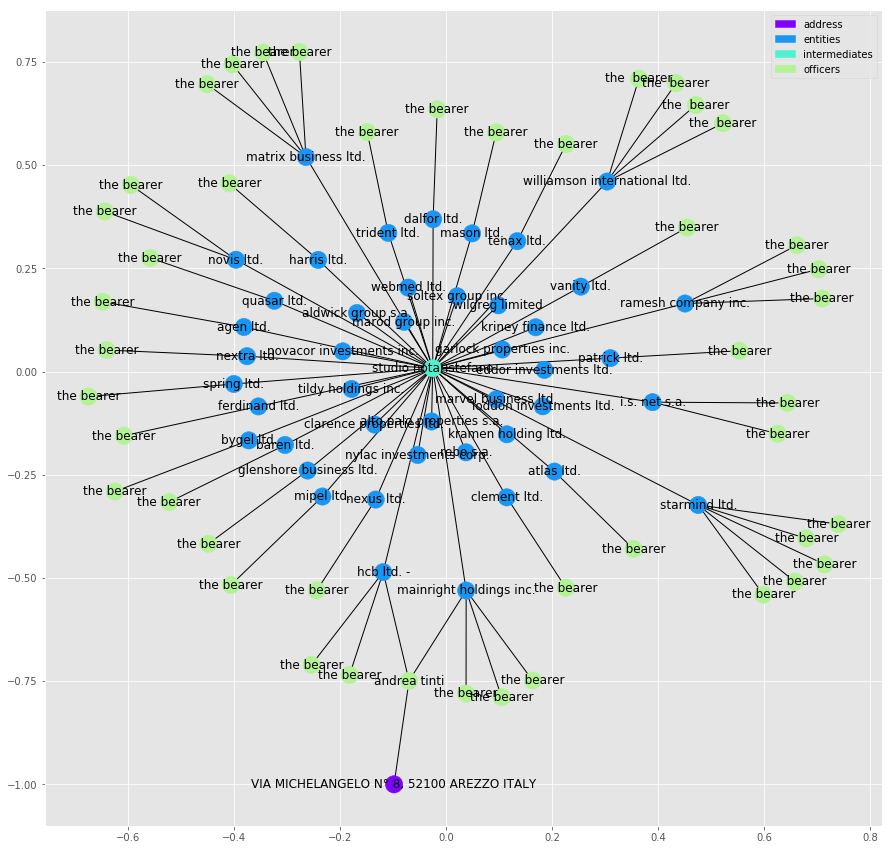

In [29]:
## interesting, this function just exists
plot_graph(subgraphs[134])

In this graph we are seeing one intermediate "studia notanstefando", acting as the intermediate for a number of entities, in this case what look like companies. You can also tell how crowded the graph is becoming. We are going to see this problem just gets worse as graph sizes grow and at some point the data becomes impossible to visualise in a concise manner.

Let us take a look at a more complex example: 

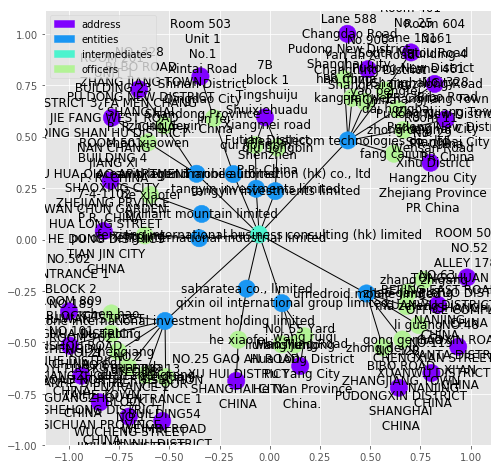

In [31]:
plot_graph(subgraphs[210], figsize=(8,8))



## The Main Network
Turning our attention to that largest connected sub-graph, we run into problems. The graph is far too big to consider plotting it and analysing it meaningfully by eye. Instead we need to try and phase our questions in such a way that the computer does the work for us.

From the graphs we saw above, it looks like the intermediaries tend to sit at the centre of things. Does this hold true in the large graph? To test this, we can find the average degree of each node type, where "degree" is the number of edges connected to a node.

In [32]:
# grab the largest subgraph
g = subgraphs[0]

In [33]:
# look at node degree
nodes = g.nodes()
g_degree = g.degree()
types = [g.node[n]["node_type"] for n in nodes]
degrees = [g_degree[n] for n in nodes]
names = [get_node_label(g.node[n]) for n in nodes]
node_degree = pd.DataFrame(data={"node_type":types, "degree":degrees, "name": names}, index=nodes)

In [34]:
# how many by node_type - Degree is how many nodes
node_degree.groupby("node_type").agg(["count", "mean", "median"])

degree                  
                count       mean median
node_type                              
address         81937   1.638222      1
entities       169676   2.509129      2
intermediates    3096  54.804910      7
officers       200770   1.924262      2

We can see that the _median_ values of each group aren't that different - 50% of most nodes have only a few edges connected to them. However the large _mean_ of the degree of intermediates suggests that the distribution is highly uneven and long tailed where there are a small number intermediaries who have a large number of the edges.

We can check this by looking at the nodes ten with the largest degree

In [35]:
node_degree.sort_values("degree", ascending=False)[0:15]

,degree,name,node_type
11001746,7016,orion house services (hk) limited,intermediates
11011863,4364,mossack fonseca & co.,intermediates
11012037,4117,prime corporate solutions sarl,intermediates
11001708,4094,offshore business consultant (int'l) limited,intermediates
11008027,3888,mossack fonseca & co. (singapore) pte ltd.,intermediates
12160432,3883,mossfon subscribers ltd.,officers
11009351,3168,consulco international limited,intermediates
11011539,2538,mossack fonseca & co. (u.k.) limited,intermediates
11009139,2055,mossack fonseca & co. (peru) corp.,intermediates
11009218,2045,"power point int'l co., ltd.",intermediates


The next few intermediates that appear are "mossack fonseca & co", "prime corporate solutions sarl", "offshore business consultant (int'l) limited" and "sealight incorporations limited". 

Given that the Intermediary appears to be a middleman that helps create the entities, it is easy to consider that each one could be linked to many entities. What isn't immediately clear is how they might be linked together. Let's take a look at the shortest path between "mossack fonseca & co" and "prime corporate solutions sarl":

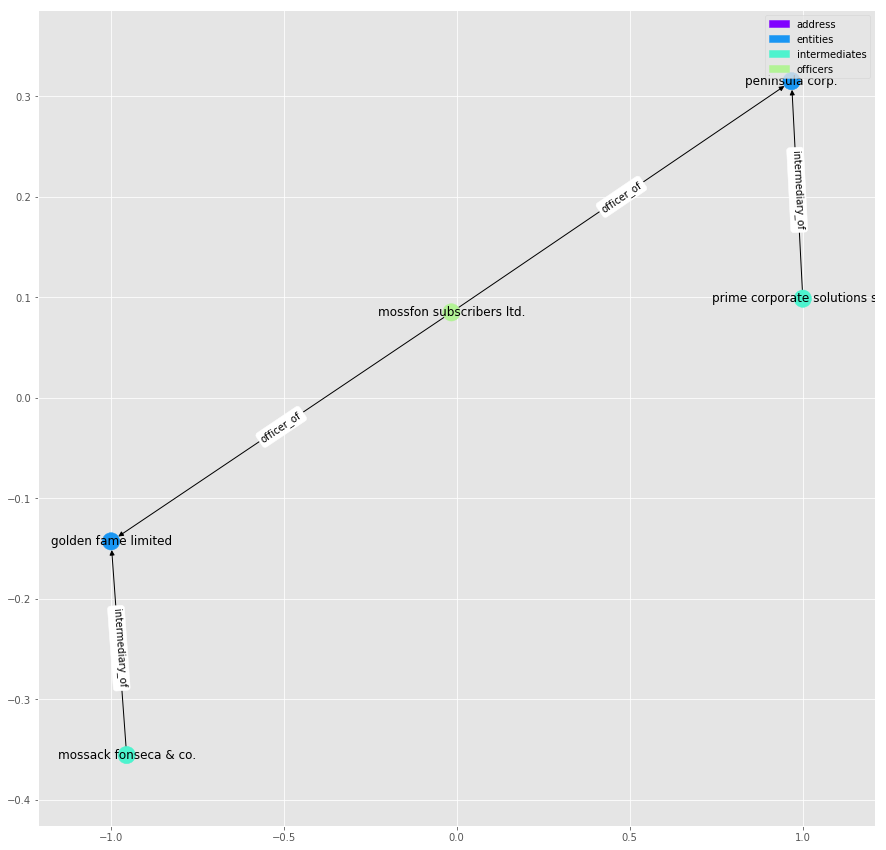

In [37]:
def plot_path(g, path):
    plot_graph(g.subgraph(path), label_edges=True)

path = nx.shortest_path(g, source=11011863, target=11012037)
plot_path(G, path)

It seems that the two intermediaries are linked together through companies who share a common director, ["mossfon subscribers ltd."]. As it’s name suggests, it also acts as director for a number of other companies:

In [41]:
offi[offi["name"]=="mossfon subscribers ltd."]

,node_id,name,country_codes,countries,sourceID,valid_until,note
10293,12012808,mossfon subscribers ltd.,NaN,NaN,Panama Papers,The Panama Papers data is current through 2015,NaN
10832,12013347,mossfon subscribers ltd.,NaN,NaN,Panama Papers,The Panama Papers data is current through 2015,NaN
22346,12024861,mossfon subscribers ltd.,NaN,NaN,Panama Papers,The Panama Papers data is current through 2015,NaN
27579,12030094,mossfon subscribers ltd.,NaN,NaN,Panama Papers,The Panama Papers data is current through 2015,NaN
44340,12046855,mossfon subscribers ltd.,NaN,NaN,Panama Papers,The Panama Papers data is current through 2015,NaN
44524,12047039,mossfon subscribers ltd.,NaN,NaN,Panama Papers,The Panama Papers data is current through 2015,NaN
44928,12047443,mossfon subscribers ltd.,NaN,NaN,Panama Papers,The Panama Papers data is current through 2015,NaN
45457,12047972,mossfon subscribers ltd.,NaN,NaN,Panama Papers,The Panama Papers data is current through 2015,NaN
45532,12048047,mossfon subscribers ltd.,NaN,NaN,Panama Papers,The Panama Papers data is current through 2015,NaN
81325,12083840,mossfon subscribers ltd.,NaN,NaN,Panama Papers,The Panama Papers data is current through 2015,NaN


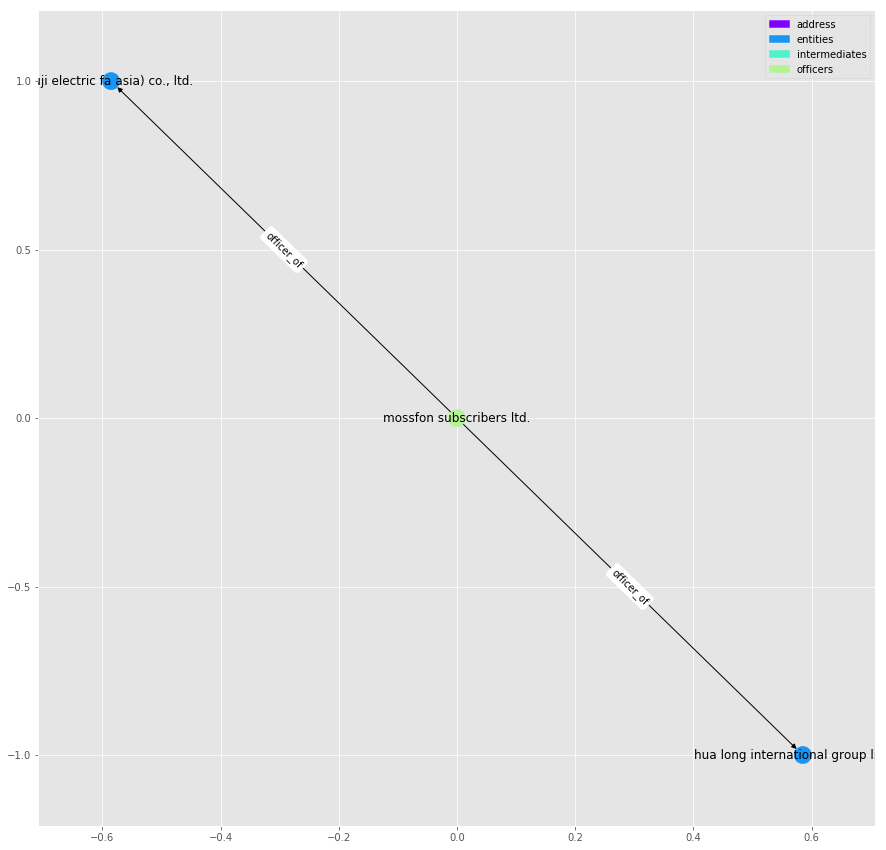

In [42]:
plot_graph(G.subgraph(nx.ego_graph(g, 12046855, radius=1).nodes()), label_edges=True)

We can do the same for, say, "mossack fonseca & co." and "sealight incorporations limited":

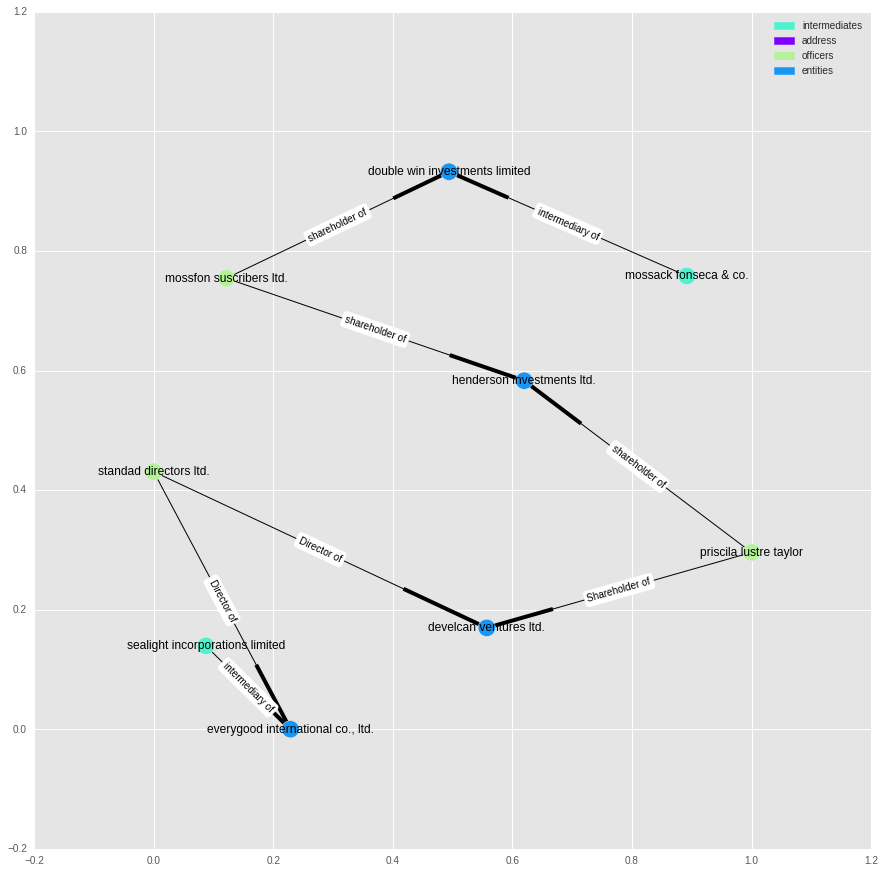

In [46]:
path = nx.shortest_path(g,11011863, 298293)
plot_path(G, path)

This chain is more convoluted, but it looks like a series of companies tied together by common shareholders or directors.

## Degree Distribution

We can also ask how the degree of the graph is distributed.

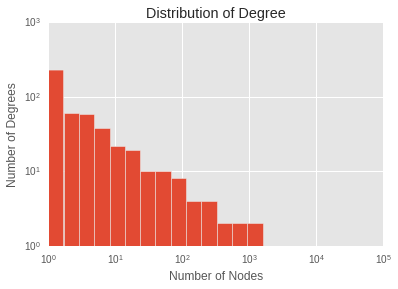

In [47]:
max_bin = max(degrees)
n_bins = 20
log_bins = [10 ** ((i/n_bins) * np.log10(max_bin)) for i in range(0,n_bins)]
fig, ax = plt.subplots()
node_degree.degree.value_counts().hist(bins=log_bins,log=True)
ax.set_xscale('log')

plt.xlabel("Number of Nodes")
plt.ylabel("Number of Degrees")
plt.title("Distribution of Degree");

If we squint, it might look like a power law distribution, giving a [scale free graph](https://en.wikipedia.org/wiki/Scale-free_network). But we'd have to be squinting.

The main result is that the distribution is long tailed - a small number of nodes are involved in most of the links.

## Node Importance

We are starting to explore how entities are connected together. Intuitively, you might expect nodes with a high degree to be the most "important" - that they sit at the centre of the graph and are closely linked to every other node. However, other measures exist.

A common measure for importance of a node is its [page rank](https://en.wikipedia.org/wiki/PageRank). Page rank is one of the measures used by google to determine the importance of a webpage, and is named after Larry Page. Essentially, if we were to perform a random walk through a graph, jumping to a random page every now and then, the time spent on each node is proportional to its page-rank.

We can calculate the page rank for each node below, and look at the top ranked nodes:

In [23]:
%time pr = nx.pagerank_scipy(g)

CPU times: user 4.06 s, sys: 0 ns, total: 4.06 s
Wall time: 4.06 s


In [24]:
node_degree["page_rank"] = node_degree.index.map(lambda x: pr[x])

In [25]:
node_degree.sort_values("page_rank", ascending=False)[0:15]

,degree,name,node_type,page_rank
236724,37329,Portcullis TrustNet Chambers P.O. Box 3444 Roa...,address,0.007766
54662,36115,portcullis trustnet (bvi) limited,officers,0.007553
11001746,7014,orion house services (hk) limited,intermediates,0.002151
11001708,4094,offshore business consultant (int'l) limited,intermediates,0.001420
11012037,4112,prime corporate solutions sarl,intermediates,0.001271
11008027,3887,mossack fonseca & co. (singapore) pte ltd.,intermediates,0.001180
96909,4253,portcullis trustnet (samoa) limited,officers,0.001013
12174256,3885,mossfon suscribers ltd.,officers,0.000963
11009139,2036,mossack fonseca & co. (peru) corp.,intermediates,0.000908
11011863,4356,mossack fonseca & co.,intermediates,0.000759


As it turns out, page rank picks out similar nodes to looking at degree. 

If I were interested in identifying the main players in setting up offshore companies, these are the intermediates that I would start looking at first.

So what happens if we look at the page rank, but just for entities?

In [26]:
node_degree[node_degree.node_type == "entities"].sort_values("page_rank", ascending=False)[0:10]

,degree,name,node_type,page_rank
10200346,998,accelonic ltd.,entities,0.000568
137067,440,hannspree inc.,entities,0.000249
153845,322,m.j. health management international holding inc.,entities,0.000178
10133161,432,dale capital group limited,entities,0.000160
10154669,242,magn development limited,entities,0.000143
10126705,203,digiwin systems group holding limited,entities,0.000114
10136878,147,mulberry holdings asset limited,entities,0.000076
10204952,158,rockover resources limited,entities,0.000074
10103570,493,vela gas investments ltd.,entities,0.000074
176625,449,wan chi investments limited,entities,0.000071


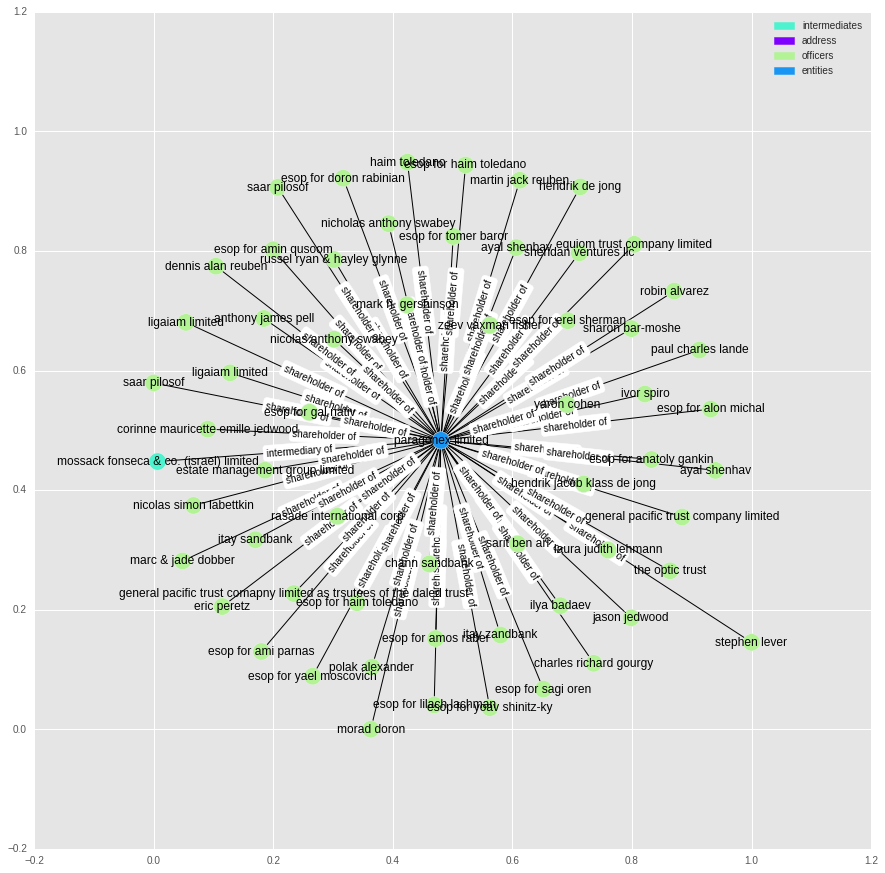

In [27]:
t = nx.ego_graph(g, 10165699, radius=1)
plot_graph(t, label_edges=True)


It looks like we just end up with the entities that have lots of shareholders and who use one of the high ranking intermediates.


# Clustering

Another measurement we can make of the "shape" of a graph is its [clustering coefficient](https://en.wikipedia.org/wiki/Clustering_coefficient). For each node, this measures how connected its neighbours are with each other. You can think of it as a measure of the local structure of the graph: what fraction of a nodes neighbours are also neighbours of each other.

In [28]:
%time cl = nx.clustering(g)

CPU times: user 4min 13s, sys: 52 ms, total: 4min 13s
Wall time: 4min 13s


In [29]:
node_degree["clustering_coefficient"] = node_degree.index.map(lambda x: cl[x])

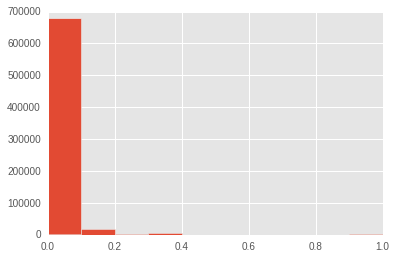

In [30]:
node_degree.clustering_coefficient.hist()

In [31]:
node_degree.sort_values(["clustering_coefficient", "degree"], ascending=False)[0:10]

,degree,name,node_type,page_rank,clustering_coefficient
122671,3,,officers,9.695260e-07,1.0
122762,3,sharecorp limited,officers,7.886701e-07,1.0
26098,2,david john bird,officers,9.492465e-07,1.0
39673,2,axisinvest corporation,officers,9.615074e-07,1.0
41341,2,healthcare lifestyle holdings limited,officers,5.569585e-07,1.0
41363,2,key enrichment limited,officers,5.543170e-07,1.0
41378,2,chuen tat overseas limited,officers,7.100476e-07,1.0
41386,2,woodwind development limited,officers,6.078500e-07,1.0
41437,2,tonga group services limited,officers,7.430761e-07,1.0
41438,2,millennium media group limited,officers,8.066175e-07,1.0


As it turns out, there isn't much structure. Most nodes have clustering coefficients of zero. The few that have non-zero values tend to have low degrees. This means that the panama paper network isn't an example of a small world network. To see what's happening in the few non-zero cases, we can look at an example sub-graph below:

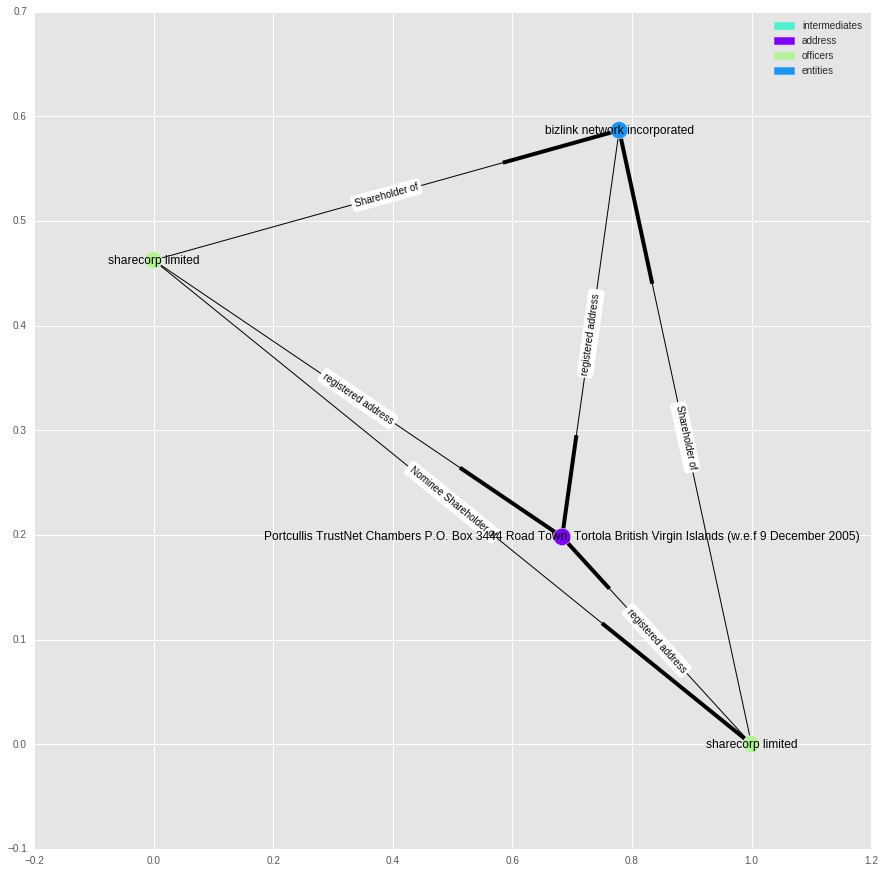

In [48]:
t = nx.ego_graph(g, 122762, radius=1)
plot_graph(G.subgraph(t), label_edges=True)

In this case, it looks like it is just due to a shared address between "sharecorp limited" and "bizlink network incorporated", and some confusion over the multiple occurrences of "sharecorp".

As a side note, I'm curious how these businesses come up with their names - I don't know anything about sharecorp limited, but it sounds like a name used as an example in economics textbooks.

## Ownership

So far we have looked at the fully connected graph, even with connections like "address of" and "intermediary of". While this does tell us that there has been nearly 40,000 businesses registered to a single address, we might want to confine ourselves to just looking at the network formed where there is some form of ownership.

Unlike our previous graph, we are going to make this one directed - this mean that each edge has a direction associated with it. For example the relationship "shareholder of" acts in one direction.

I've collected together all the relationships I think involve some kind of ownership, but I am not a lawyer or accountant, so these may be wrong.

In [33]:
owner_rels = set({
    'shareholder of',
    'Shareholder of',
    'Director / Shareholder of',
    'Director of',
    'Director (Rami Makhlouf) of',
    'Power of Attorney of',
    'Director / Shareholder / Beneficial Owner of',
    'Member / Shareholder of',
    'Owner of',
    'Beneficial Owner of',
    'Power of attorney of',
    'Owner, director and shareholder of',
    'President - Director of',
    'Sole shareholder of',
    'President and director of',
    'Director / Beneficial Owner of',
    'Power of Attorney / Shareholder of',
    'Director and shareholder of',
    'beneficiary of',
    'President of',
    'Member of Foundation Council of',
    'Beneficial owner of',
    'Sole signatory of',
    'Sole signatory / Beneficial owner of',
    'Principal beneficiary of',
    'Protector of',
    'Beneficiary, shareholder and director of',
    'Beneficiary of',
    'Shareholder (through Julex Foundation) of',
    'First beneficiary of',
    'Authorised Person / Signatory of',
    'Successor Protector of',
    'Register of Shareholder of',
    'Reserve Director of',
    'Resident Director of',
    'Alternate Director of',
    'Nominated Person of',
    'Register of Director of',
    'Trustee of Trust of',
    'Personal Directorship of',
    'Unit Trust Register of',
    'Chairman of',
    'Board Representative of',
    'Custodian of',
    'Nominee Shareholder of',
    'Nominee Director of',
    'Nominee Protector of',
    'Nominee Investment Advisor of',
    'Nominee Trust Settlor of',
    'Nominee Beneficiary of',
    'Nominee Secretary of',
    'Nominee Beneficial Owner of'
});

In [34]:
# copy main graph
g2 = G.copy()

# remove non-ownership edges
for e in g2.edges(data=True):
    if e[2]["rel_type"] not in owner_rels:
        g2.remove_edge(e[0], e[1])
        
# get all subgraphs
subgraphs = [sg for sg in nx.connected_component_subgraphs(g2.to_undirected())]
subgraphs = sorted(subgraphs, key=lambda x: x.number_of_nodes(), reverse=True)
len(subgraphs)

401655

In [35]:
g2.number_of_edges()

465646

Removing two thirds of the nodes breaks this graph into lots of smaller sub-graphs. Most of these graphs are uninteresting and simply reflect that one company is owned by a large number of shareholders. Consider the graph below:

(Note: we are now looking at a "directed" graph. The edges are slightly wider at one end to represent their directionality)

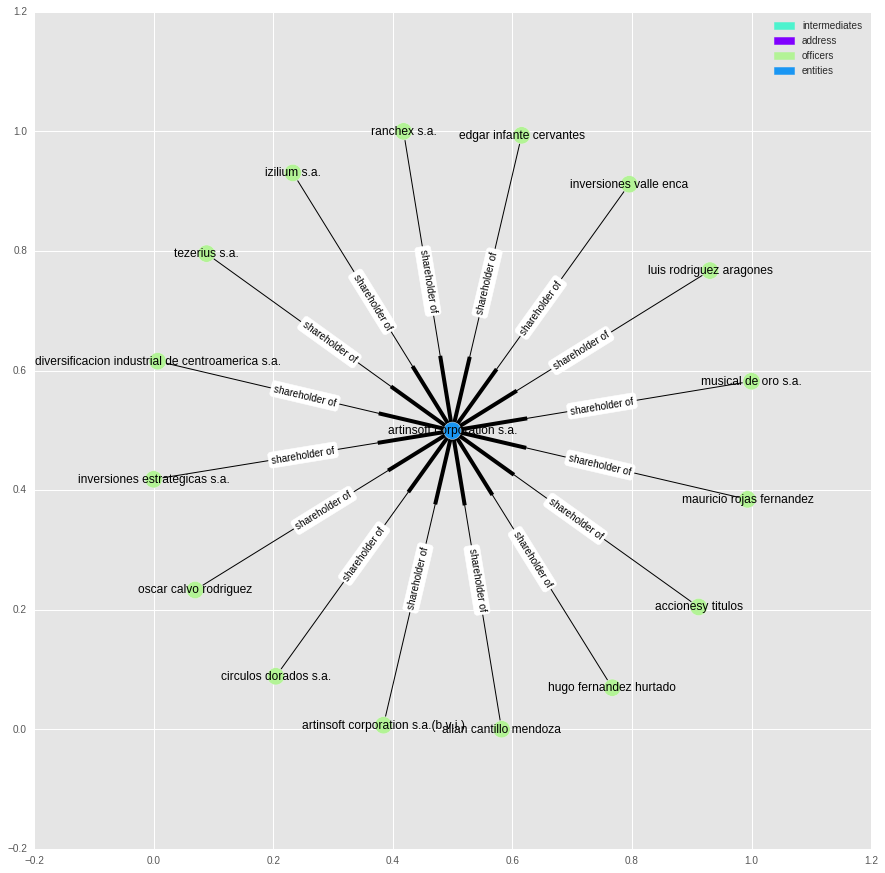

In [36]:
tt = subgraphs[1000].nodes()
plot_graph(g2.subgraph(tt), label_edges=True)

To identify more interesting structures, we can look at sub-graphs with the largest median node degree:

In [37]:
avg_deg = pd.Series(data=[np.median(list(sg.degree().values())) for sg in subgraphs],
                    index=range(0,len(subgraphs)))

In [38]:
avg_deg.sort_values(ascending=False)[0:10]

790     6.0
582     6.0
268     5.0
2643    5.0
2040    5.0
263     4.5
1420    4.0
1904    4.0
745     4.0
3271    4.0
dtype: float64

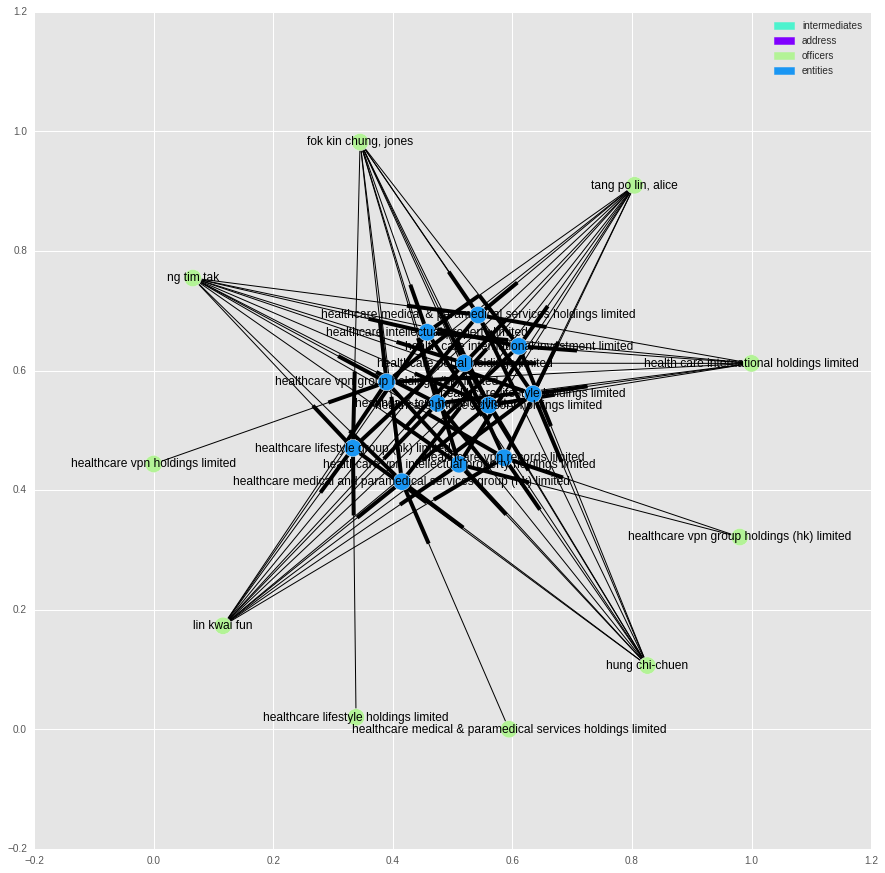

In [39]:
tt = subgraphs[582].nodes()
plot_graph(g2.subgraph(tt))

In these cases we are looking at a small group of companies that share the same owners.

## The Longest Line

We can also ask what the longest chain of ownership links is:

The longest path is 4 nodes long.


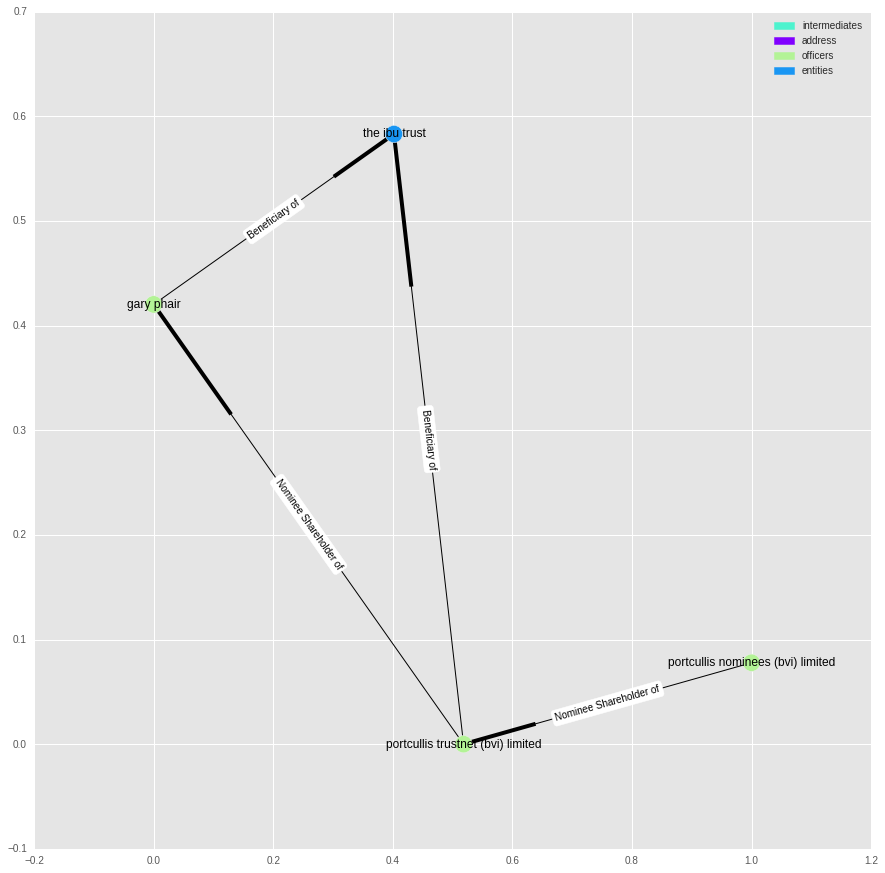

In [40]:
lp = nx.dag_longest_path(g2)
print("The longest path is {} nodes long.".format(len(lp)))
plot_graph(g2.subgraph(lp), label_edges=True)

It is surprisingly short.

And with that, I have finished my explorations.

I'd like to reiterate that without prior knowledge of this sort of network, it is hard to know what constitutes an "interesting" business/entities structure, or what might be the sign of potentially criminal/immoral behaviour. My guess is that no single measure captures it completely, but rather we could combine multiple measures, and some machine learning to automatically identify those areas for future inquiry. In fact, I'd be surprised if this wasn't already being done somewhere. 

That's about all I have to say for now on this network. I'm sure there is more that can be done, and interesting questions that can be asked and answered, but I lack the background required to know where to start. If this is something you are interested in and have some ideas about where to go, [please get in touch](mailto:iain@degeneratestate.org).

## How it was Made
This post was created as a jupyter notebook. You can find the notebook, the data and code used to create it [here](https://github.com/ijmbarr/panama-paper-network).